"""
A utility file which includes functions to obtain data from alpaca api, plot efficient frontier. 

"""

In [11]:
# to import libraries
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import numpy as np
%matplotlib inline

In [12]:
def get_data(tickers):
    """
    Download data for the selected tickers from ALPACA API with the API keys
    stored in the 'api.env' document 
    """
    load_dotenv('api.env')
    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    alpaca = tradeapi.REST(
     alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    
    timeframe = '1D'

    start_date = pd.Timestamp("2020-06-30", tz="America/New_York").isoformat()
    end_date = pd.Timestamp("2021-10-31", tz="America/New_York").isoformat()
    
    price_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
    ).df
    
    return price_df

In [13]:
def asset_return(asset):
    return_df = asset.pct_change().dropna()
    return return_df

In [14]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

In [15]:
def portfolio_return(weights, returns):
    """
    Weights -> Portfolio Returns
    """
    return weights.T @ returns

In [16]:
def portfolio_vol(weights,covmat):
    """
    Weights -> Vol
    """
    return (weights.T @ covmat @ weights)**0.5

In [17]:
def plot_ef2(n_points, er, cov, style = ".-"):
    """
    Plots the 2-asset efficient frontier
    """

    
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=style, figsize = (15,10), color = "pink", legend = False, title = "Efficient Frontier of the Portfolio")

In [18]:
# to put in the -main- file

portfolio_data = get_data(tickers = ["AGG,SPY"])
AGG_return = asset_return(portfolio_data["AGG"]["close"])
SPY_return = asset_return(portfolio_data["SPY"]["close"])
returns_AGG_SPY = pd.concat ([AGG_return, SPY_return], axis = 1)
er = annualize_rets(returns_AGG_SPY, 252)
cov = returns_AGG_SPY.cov()

<AxesSubplot:title={'center':'Efficient Frontier of the Portfolio'}, xlabel='Volatility'>

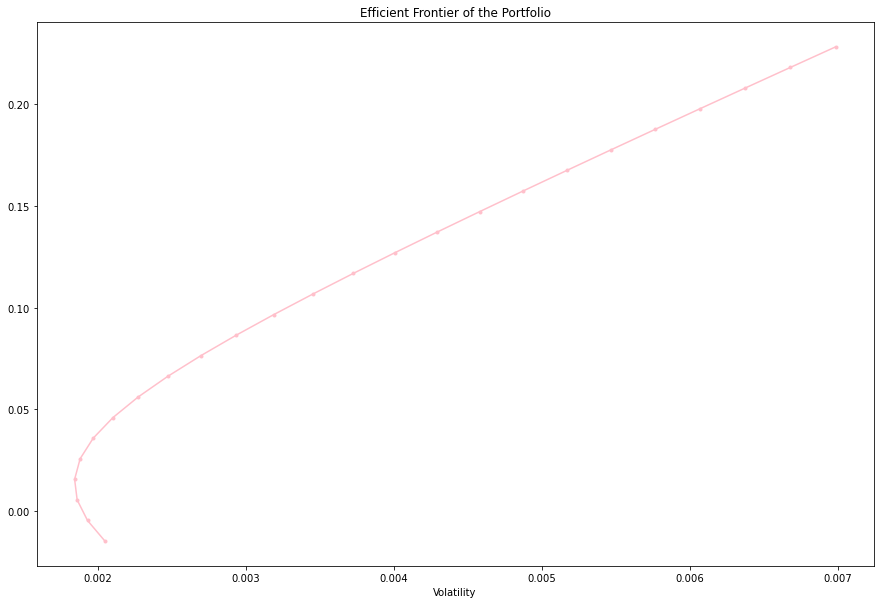

In [19]:
# to run in the -main- file 
plot_ef2(25, er, cov, style = '.-')

In [20]:
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    target_ret -> W
    """
    n = er.shape[0]
    init_guess = np.repeat (1/n,n)
    bounds = ((0.0, 1.0),)*n
    return_is_target = {
        'type': 'eq',
        'args': (er,),
        'fun': lambda weights, er: target_return - portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    results = minimize(portfolio_vol, init_guess, 
                       args = (cov,), method="SLSQP",
                       options = {'disp': False},
                       constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [21]:
def optimal_weights(n_points, er, cov):
    """
    -> list of weights to run the optmizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(),er.max(),n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

In [22]:
def msr(riskfree_rate, er, cov):
    """
    RiskFree rate + ER + COV -> W
    Returns the weights of the portfolio that gives you the maximum sharpe ratio given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat (1/n,n)
    bounds = ((0.0, 1.0),)*n
    weights_sum_to_1 = {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratios, given weights
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess, 
                       args = (riskfree_rate, er,cov,), method="SLSQP",
                       options = {'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds
                      )
    return results.x

In [23]:
def gmv(cov):
    """
    Returns the weight of the Global Minimum Vol portfolio
    given the covariance matris
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1,n), cov)

In [24]:
def plot_ef(n_points, er, cov, show_cml=False, style='.-', riskfree_rate=0.1, show_ew=False, show_gmv=False):
    """
    Plots the multi-asset efficient frontier
    """

    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    ax= ef.plot.line(x="Volatility", y="Returns", style=style)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # display EW
        ax.plot([vol_ew],[r_ew],color="goldenrod", marker="o",markersize=12)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # display GMV
        ax.plot([vol_gmv], [r_gmv], color = "midnightblue", marker = "o", markersize = 10)
    if show_cml:
        ax.set_xlim(left = 0)
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # Add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color = "green", marker = "o", linestyle = "dashed", markersize=12, linewidth=2)
        
    return ax

<AxesSubplot:xlabel='Volatility'>

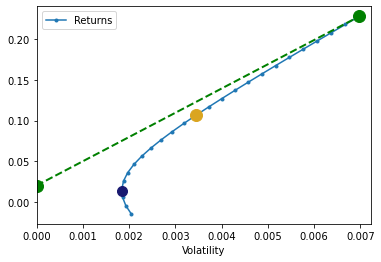

In [29]:
plot_ef(25, er, cov, show_cml = True, style = '.-', riskfree_rate = 0.02, show_ew = True, show_gmv = True) 

In [30]:
msr(0.02, er, cov)

array([5.42343948e-13, 1.00000000e+00])

In [31]:
gmv(cov)

array([0.8827479, 0.1172521])